### Architecture idea (SIMPLE DIAGRAM)

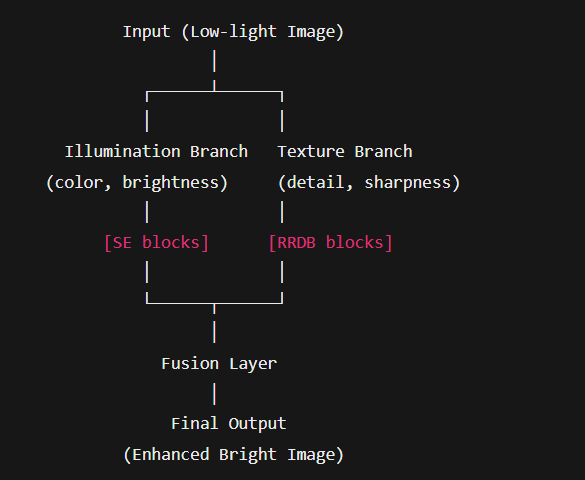

In [111]:
!pip install numpy
!pip install torchmetrics
!pip install piq
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 17.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 KB 21.8 MB/s eta 0:00:00


In [86]:
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import PeakSignalNoiseRatio as PSNR, StructuralSimilarityIndexMeasure as SSIM
from piq import LPIPS
import os
import torch.nn.functional as F
from torchvision.models import vgg19
from torchvision.utils import save_image
from torchvision.datasets import DatasetFolder
from datetime import datetime
from sklearn.model_selection import train_test_split

In [4]:
# def set_seed(seed=42):
#     """Set all random seeds for reproducibility."""
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)  # if using multi-GPU
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# # Set the seed (choose any number you like)
# set_seed(42) 

# Run Data

In [87]:
dataset_path1 = '/home/gsalsabil2/dl_kapel/augmented_images'
train_path = f'{dataset_path1}/train'
val_path = f'{dataset_path1}/val'
test_path = f'{dataset_path1}/test'

In [88]:
target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [89]:
class CleanDataset(Dataset):
    def __init__(self, root_dir, target_transform=None):
        self.root_dir = root_dir
        self.target_transform = target_transform
        self.low_dir = os.path.join(root_dir, "low")
        self.high_dir = os.path.join(root_dir, "high")
        self.image_names = sorted(os.listdir(self.low_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_dir, self.image_names[idx])
        high_img_path = os.path.join(self.high_dir, self.image_names[idx])

        low_img = Image.open(low_img_path).convert("RGB")
        high_img = Image.open(high_img_path).convert("RGB")

        if self.target_transform:
            low_img = self.target_transform(low_img)
            high_img = self.target_transform(high_img)
            
            
        low_filename = os.path.basename(low_img_path)
        high_filename = os.path.basename(high_img_path)
        
        return low_img, high_img, low_filename, high_filename

train_dataset = CleanDataset(
    root_dir=train_path, 
    target_transform = target_transform
)

val_dataset = CleanDataset(
    root_dir=val_path,
    target_transform = target_transform
)

test_dataset = CleanDataset(root_dir=test_path, target_transform = target_transform)

In [90]:
batch_size=8

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True   # Speeds up transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,         # No need for validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,       # Often use batch_size=1 for testing
    shuffle=False,
    num_workers=1
)

In [91]:
def show_true_images(low_batch, high_batch, n=4):

    """
    Shows EXACTLY what's in your dataset with correct color handling.
    Works for both normalized and unnormalized images.
    """

    plt.figure(figsize=(18, 8))

    for i in range(min(n, len(low_batch))):
        # --- Low-light ---
        plt.subplot(2, n, i+1)
        low_img = low_batch[i].permute(1, 2, 0).numpy()

        # Handle normalization if present
        if low_img.min() < 0:  # Likely normalized
            low_img = (low_img * 0.5 + 0.5)  # Reverse imagenet norm

        # Ensure proper image range
        low_img = np.clip(low_img, 0, 1)
        plt.imshow(low_img)
        plt.title(f"Low")
        plt.axis('off')

        # --- Normal-light ---
        plt.subplot(2, n, n+i+1)
        high_img = high_batch[i].permute(1, 2, 0).numpy()

        if high_img.min() < 0:  # Likely normalized
            high_img = (high_img * 0.5 + 0.5)

        high_img = np.clip(high_img, 0, 1)
        plt.imshow(high_img)
        plt.title(f"High")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Low resolution file name: ['566.png', '84.png', '42.png', '629.png', '231.png', '247.png', '758.png', '731.png']
High resolution file name: ['566.png', '84.png', '42.png', '629.png', '231.png', '247.png', '758.png', '731.png']


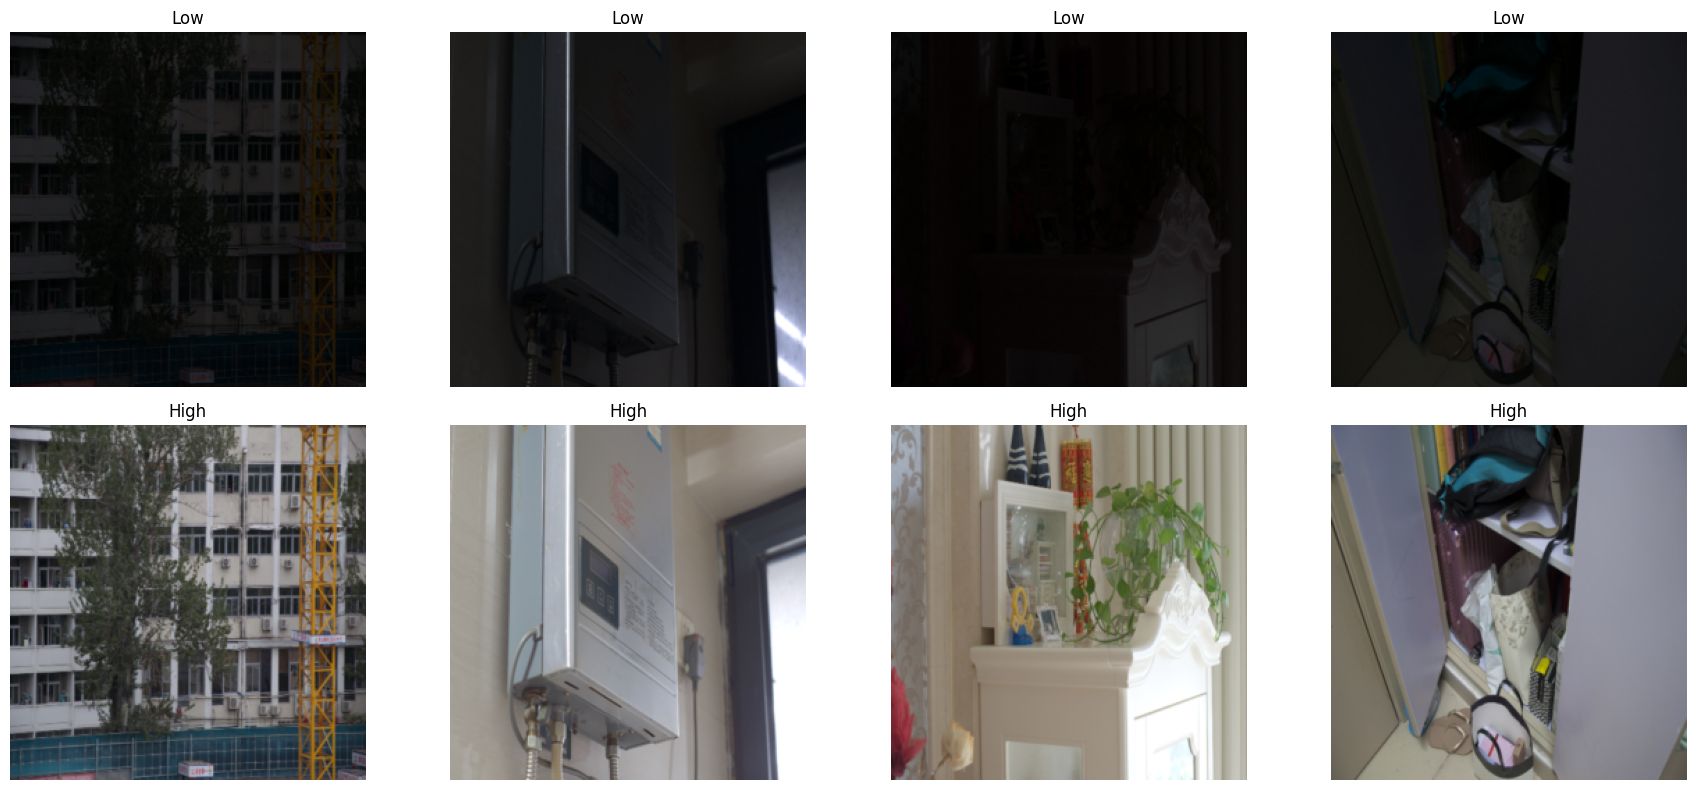

In [92]:
low, high, low_filename, high_filename = next(iter(train_loader))
print("Low resolution file name:", low_filename)
print("High resolution file name:", high_filename)
show_true_images(low, high)

# MODEL ARCHITECTURE

In [60]:
#SE Blocks:

class SEBlock(nn.Module):
    """Squeeze-and-Excitation block for channel attention"""

    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


# Residual-in-Residual Dense Block (RRDB)

class RRDB(nn.Module):
    """Residual-in-Residual Dense Block"""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels*2, channels, 3, padding=1)
        self.conv3 = nn.Conv2d(channels*3, channels, 3, padding=1)
        self.lrelu = nn.LeakyReLU(0.2)
        self.se = SEBlock(channels)

    def forward(self, x):
        out1 = self.lrelu(self.conv1(x))
        out2 = self.lrelu(self.conv2(torch.cat([x, out1], 1)))
        out3 = self.conv3(torch.cat([x, out1, out2], 1))
        return self.se(out3 * 0.2 + x)  # Residual scaling


Generator


In [61]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Illumination Branch (color/brightness)
        self.illum_conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.illum_rrdb = nn.Sequential(*[RRDB(32) for _ in range(4)])
        self.illum_conv2 = nn.Conv2d(32, 3, 3, padding=1)

        # Texture Branch (detail/sharpness)
        self.texture_conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.texture_rrdb = nn.Sequential(*[RRDB(64) for _ in range(6)])
        self.texture_conv2 = nn.Conv2d(64, 3, 3, padding=1)

        # Fusion
        self.fusion = nn.Sequential(
            nn.Conv2d(6, 32, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Tanh()  # Output in [-1,1] -> remap to [0,1] later
        )

    def forward(self, x):
        # Illumination path
        illum = self.illum_conv1(x)
        illum = self.illum_rrdb(illum)
        illum = torch.sigmoid(self.illum_conv2(illum))  # [0,1]

        # Texture path
        texture = self.texture_conv1(x)
        texture = self.texture_rrdb(texture)
        texture = self.texture_conv2(texture)  # No activation (keep details)

        # Fusion
        fused = self.fusion(torch.cat([illum, texture], 1))
        return (fused + 1) / 2  # Map to [0,1]

Discriminator

In [62]:
class Discriminator(nn.Module):
    """PatchGAN discriminator"""
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Input: 3 x 256 x 256
            nn.Conv2d(3, 64, 4, stride=2, padding=1),  # 128
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 64
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # 32
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, stride=1, padding=1),  # 31
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, stride=1, padding=1)  # 30x30 patch output
        )

    def forward(self, x):
        return self.model(x)

Loss Functions


In [63]:
class GANLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, pred, target_is_real):
        target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
        return self.loss(pred, target)


class PerceptualLoss(nn.Module):

    """VGG-based perceptual loss"""

    def __init__(self):
        super().__init__()
        vgg = vgg19(pretrained=True).features[:16]
        self.vgg = nn.Sequential(*[m for m in vgg if not isinstance(m, nn.MaxPool2d)])
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        vgg_input = F.interpolate(input, size=(224,224)) if input.shape[-1] != 224 else input
        vgg_target = F.interpolate(target, size=(224,224)) if target.shape[-1] != 224 else target
        return F.l1_loss(self.vgg(vgg_input), self.vgg(vgg_target))

# Training preparation:

In [64]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Hyperparameters
config = {
    'batch_size': 8,
    'epochs': 200,
    'lr_g': 2e-4,
    'lr_d': 1e-4,
    'betas': (0.5, 0.999),
    'lambda_l1': 100,
    'lambda_perceptual': 0.1,
    'save_interval': 1,  # Save every epoch
    'sample_interval': 100,  # Generate samples every N batches
}

# Initialize models and losses
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Losses
criterion_gan = GANLoss()
criterion_l1 = nn.L1Loss()
criterion_perceptual = PerceptualLoss().to(device)

# Optimizers with LR scheduling
opt_g = torch.optim.Adam(generator.parameters(), lr=config['lr_g'], betas=config['betas'])
opt_d = torch.optim.Adam(discriminator.parameters(), lr=config['lr_d'], betas=config['betas'])
scheduler_g = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_g, 'min', patience=5, factor=0.5)
scheduler_d = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_d, 'min', patience=5, factor=0.5)

# Initialize metrics
psnr = PSNR().to(device)
ssim = SSIM().to(device)
lpips = LPIPS(replace_pooling=True).to(device)

/home/gsalsabil2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gsalsabil2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/gsalsabil2/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/home/gsalsabil2/.local/lib/python3.10/site-packages/torchmetrics/utilit

# Training LOOP

In [65]:
def validate(generator, val_loader, epoch):
    """Evaluate model on validation set"""
    generator.eval()
    val_metrics = {'psnr': 0, 'ssim': 0, 'lpips': 0}

    with torch.no_grad():
        for low, high, *_ in tqdm(val_loader, desc=f'Validation Epoch {epoch}', leave=False):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Update metrics
            val_metrics['psnr'] += psnr(fake, high)
            val_metrics['ssim'] += ssim(fake, high)
            val_metrics['lpips'] += lpips(fake, high)

    # Average across batches
    for k in val_metrics:
        val_metrics[k] /= len(val_loader)

    return val_metrics

In [67]:
def train_gan(
    generator,
    discriminator,
    train_loader,
    val_loader,
    criterion_gan,
    criterion_l1,
    criterion_perceptual,
    opt_g,
    opt_d,
    epochs,
    device,
    save_dir="RRDB_SE_CHECKPOINTS"
):
    os.makedirs(save_dir, exist_ok=True)
    best_ssim = 0
    best_lpips = 100
    best_psnr = 0

    for epoch in range(epochs):
        # Training phase
        generator.train()
        discriminator.train()

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for low, high, *_ in train_bar:
            low, high = low.to(device), high.to(device)

            # --- Discriminator Update ---
            opt_d.zero_grad()

            # Real images
            real_pred = discriminator(high)
            real_loss = criterion_gan(real_pred, True)

            # Fake images
            fake = generator(low).detach()
            fake_pred = discriminator(fake)
            fake_loss = criterion_gan(fake_pred, False)

            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            opt_d.step()

            # --- Generator Update ---
            opt_g.zero_grad()
            fake = generator(low)
            g_gan_loss = criterion_gan(discriminator(fake), True)
            g_l1_loss = criterion_l1(fake, high) * 100
            g_perc_loss = criterion_perceptual(fake, high) * 0.1
            g_loss = g_gan_loss + g_l1_loss + g_perc_loss
            g_loss.backward()
            opt_g.step()

            # Update progress bar
            train_bar.set_postfix({
                'D_loss': f'{d_loss.item():.3f}',
                'G_loss': f'{g_loss.item():.3f}',
                'L1': f'{g_l1_loss.item():.3f}'
            })

        # Validation phase
        val_metrics = validate(generator, val_loader, epoch+1)

        # Print metrics
        print(f"\nValidation @ Epoch {epoch+1}:")
        print(f"PSNR: {val_metrics['psnr']:.2f} dB | SSIM: {val_metrics['ssim']:.4f} | LPIPS: {val_metrics['lpips']:.4f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch+1,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'opt_g': opt_g.state_dict(),
            'opt_d': opt_d.state_dict(),
            'metrics': val_metrics
        }, os.path.join(save_dir, f'epoch_{epoch+1}.pth'))

        # Save best model
        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_model.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips_ssim.pth'))
            print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_ssim.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_lpips.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f}) saved!")
                
        if val_metrics['ssim'] > best_ssim:
            best_ssim = val_metrics['ssim']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_ssim.pth'))
            print(f"🔥 New best model (SSIM: {best_ssim:.4f}) saved!")
                    
        if val_metrics['psnr'] > best_psnr:
            best_psnr = val_metrics['psnr']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr.pth'))
            print(f"🔥 New best model (PSNR: {best_psnr:.4f}) saved!")

        if val_metrics['lpips'] < best_lpips:
            best_lpips = val_metrics['lpips']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
            print(f"🔥 New best model (LPIPS: {best_lpips:.4f}) saved!")

            
        # Sample images
        if (epoch+1) % 5 == 0:
            with torch.no_grad():
                fake = generator(low[:3])  # First 3 samples
                save_image(
                    torch.cat([low[:3], fake, high[:3]], 0),
                    os.path.join(save_dir, f'sample_epoch_{epoch+1}.png'),
                    nrow=3,
                    normalize=True
                )


In [68]:
# Usage
train_gan(
    generator=generator,
    discriminator=discriminator,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion_gan=criterion_gan,
    criterion_l1=criterion_l1,
    criterion_perceptual=criterion_perceptual,
    opt_g=opt_g,
    opt_d=opt_d,
    epochs=200,
    device=device
)

Epoch 1/200: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s, D_loss=0.287, G_loss=20.926, L1=18.430]



Validation @ Epoch 1:
PSNR: 14.41 dB | SSIM: 0.5571 | LPIPS: 0.5553
🔥 New best model (PSNR: 14.4131 | LPIPS: 0.5553 | SSIM: 0.5571) saved!
🔥 New best model (LPIPS: 0.5553 | SSIM: 0.5571) saved!
🔥 New best model (PSNR: 14.4131 | SSIM: 0.5571) saved!
🔥 New best model (PSNR: 14.4131 | LPIPS: 0.5553) saved!
🔥 New best model (SSIM: 0.5571) saved!
🔥 New best model (PSNR: 14.4131) saved!
🔥 New best model (LPIPS: 0.5553) saved!


Epoch 2/200: 100%|██████████| 49/49 [00:22<00:00,  2.14it/s, D_loss=0.196, G_loss=20.884, L1=18.485]



Validation @ Epoch 2:
PSNR: 15.62 dB | SSIM: 0.6209 | LPIPS: 0.5234
🔥 New best model (PSNR: 15.6200 | LPIPS: 0.5234 | SSIM: 0.6209) saved!
🔥 New best model (LPIPS: 0.5234 | SSIM: 0.6209) saved!
🔥 New best model (PSNR: 15.6200 | SSIM: 0.6209) saved!
🔥 New best model (PSNR: 15.6200 | LPIPS: 0.5234) saved!
🔥 New best model (SSIM: 0.6209) saved!
🔥 New best model (PSNR: 15.6200) saved!
🔥 New best model (LPIPS: 0.5234) saved!


Epoch 3/200: 100%|██████████| 49/49 [00:23<00:00,  2.11it/s, D_loss=0.237, G_loss=17.505, L1=14.850]



Validation @ Epoch 3:
PSNR: 16.31 dB | SSIM: 0.6348 | LPIPS: 0.5039
🔥 New best model (PSNR: 16.3133 | LPIPS: 0.5039 | SSIM: 0.6348) saved!
🔥 New best model (LPIPS: 0.5039 | SSIM: 0.6348) saved!
🔥 New best model (PSNR: 16.3133 | SSIM: 0.6348) saved!
🔥 New best model (PSNR: 16.3133 | LPIPS: 0.5039) saved!
🔥 New best model (SSIM: 0.6348) saved!
🔥 New best model (PSNR: 16.3133) saved!
🔥 New best model (LPIPS: 0.5039) saved!


Epoch 4/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.181, G_loss=16.889, L1=14.278]



Validation @ Epoch 4:
PSNR: 15.47 dB | SSIM: 0.6190 | LPIPS: 0.5662


Epoch 5/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.377, G_loss=15.900, L1=13.536]



Validation @ Epoch 5:
PSNR: 15.50 dB | SSIM: 0.6429 | LPIPS: 0.4863
🔥 New best model (LPIPS: 0.4863 | SSIM: 0.6429) saved!
🔥 New best model (SSIM: 0.6429) saved!
🔥 New best model (LPIPS: 0.4863) saved!


Epoch 6/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.120, G_loss=17.051, L1=14.214]



Validation @ Epoch 6:
PSNR: 16.11 dB | SSIM: 0.6483 | LPIPS: 0.4551
🔥 New best model (LPIPS: 0.4551 | SSIM: 0.6483) saved!
🔥 New best model (SSIM: 0.6483) saved!
🔥 New best model (LPIPS: 0.4551) saved!


Epoch 7/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.154, G_loss=17.178, L1=14.427]



Validation @ Epoch 7:
PSNR: 17.25 dB | SSIM: 0.7130 | LPIPS: 0.3907
🔥 New best model (PSNR: 17.2533 | LPIPS: 0.3907 | SSIM: 0.7130) saved!
🔥 New best model (LPIPS: 0.3907 | SSIM: 0.7130) saved!
🔥 New best model (PSNR: 17.2533 | SSIM: 0.7130) saved!
🔥 New best model (PSNR: 17.2533 | LPIPS: 0.3907) saved!
🔥 New best model (SSIM: 0.7130) saved!
🔥 New best model (PSNR: 17.2533) saved!
🔥 New best model (LPIPS: 0.3907) saved!


Epoch 8/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.216, G_loss=18.150, L1=14.875]



Validation @ Epoch 8:
PSNR: 16.54 dB | SSIM: 0.6927 | LPIPS: 0.4070


Epoch 9/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.236, G_loss=13.808, L1=11.067]



Validation @ Epoch 9:
PSNR: 16.85 dB | SSIM: 0.7153 | LPIPS: 0.3858
🔥 New best model (LPIPS: 0.3858 | SSIM: 0.7153) saved!
🔥 New best model (SSIM: 0.7153) saved!
🔥 New best model (LPIPS: 0.3858) saved!


Epoch 10/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.164, G_loss=12.270, L1=10.053]



Validation @ Epoch 10:
PSNR: 16.84 dB | SSIM: 0.7003 | LPIPS: 0.4062


Epoch 11/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.427, G_loss=11.609, L1=9.535] 



Validation @ Epoch 11:
PSNR: 17.42 dB | SSIM: 0.7127 | LPIPS: 0.3870
🔥 New best model (PSNR: 17.4213) saved!


Epoch 12/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.340, G_loss=12.102, L1=9.713] 



Validation @ Epoch 12:
PSNR: 17.16 dB | SSIM: 0.7150 | LPIPS: 0.3805
🔥 New best model (LPIPS: 0.3805) saved!


Epoch 13/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.220, G_loss=10.593, L1=7.574] 



Validation @ Epoch 13:
PSNR: 17.38 dB | SSIM: 0.7258 | LPIPS: 0.3756
🔥 New best model (LPIPS: 0.3756 | SSIM: 0.7258) saved!
🔥 New best model (SSIM: 0.7258) saved!
🔥 New best model (LPIPS: 0.3756) saved!


Epoch 14/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.148, G_loss=13.883, L1=10.821]



Validation @ Epoch 14:
PSNR: 17.04 dB | SSIM: 0.7057 | LPIPS: 0.3912


Epoch 15/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.403, G_loss=17.691, L1=15.045]



Validation @ Epoch 15:
PSNR: 17.55 dB | SSIM: 0.7136 | LPIPS: 0.3798
🔥 New best model (PSNR: 17.5453) saved!


Epoch 16/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.634, G_loss=9.461, L1=8.646]  



Validation @ Epoch 16:
PSNR: 17.69 dB | SSIM: 0.7406 | LPIPS: 0.3543
🔥 New best model (PSNR: 17.6859 | LPIPS: 0.3543 | SSIM: 0.7406) saved!
🔥 New best model (LPIPS: 0.3543 | SSIM: 0.7406) saved!
🔥 New best model (PSNR: 17.6859 | SSIM: 0.7406) saved!
🔥 New best model (PSNR: 17.6859 | LPIPS: 0.3543) saved!
🔥 New best model (SSIM: 0.7406) saved!
🔥 New best model (PSNR: 17.6859) saved!
🔥 New best model (LPIPS: 0.3543) saved!


Epoch 17/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.835, G_loss=9.587, L1=7.859]  



Validation @ Epoch 17:
PSNR: 17.43 dB | SSIM: 0.7134 | LPIPS: 0.3994


Epoch 18/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.380, G_loss=14.137, L1=11.066]



Validation @ Epoch 18:
PSNR: 17.75 dB | SSIM: 0.7461 | LPIPS: 0.3972
🔥 New best model (PSNR: 17.7490 | SSIM: 0.7461) saved!
🔥 New best model (SSIM: 0.7461) saved!
🔥 New best model (PSNR: 17.7490) saved!


Epoch 19/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.305, G_loss=10.010, L1=8.757] 



Validation @ Epoch 19:
PSNR: 17.58 dB | SSIM: 0.7634 | LPIPS: 0.3577
🔥 New best model (SSIM: 0.7634) saved!


Epoch 20/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.520, G_loss=15.720, L1=13.575]



Validation @ Epoch 20:
PSNR: 17.12 dB | SSIM: 0.7600 | LPIPS: 0.3685


Epoch 21/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.372, G_loss=15.813, L1=13.840]



Validation @ Epoch 21:
PSNR: 17.86 dB | SSIM: 0.7646 | LPIPS: 0.3620
🔥 New best model (PSNR: 17.8641 | SSIM: 0.7646) saved!
🔥 New best model (SSIM: 0.7646) saved!
🔥 New best model (PSNR: 17.8641) saved!


Epoch 22/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.451, G_loss=14.656, L1=12.675]



Validation @ Epoch 22:
PSNR: 17.41 dB | SSIM: 0.7629 | LPIPS: 0.3837


Epoch 23/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.390, G_loss=10.230, L1=6.763] 



Validation @ Epoch 23:
PSNR: 17.59 dB | SSIM: 0.7758 | LPIPS: 0.3301
🔥 New best model (LPIPS: 0.3301 | SSIM: 0.7758) saved!
🔥 New best model (SSIM: 0.7758) saved!
🔥 New best model (LPIPS: 0.3301) saved!


Epoch 24/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.508, G_loss=10.352, L1=7.838] 



Validation @ Epoch 24:
PSNR: 17.80 dB | SSIM: 0.7776 | LPIPS: 0.3886
🔥 New best model (SSIM: 0.7776) saved!


Epoch 25/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.172, G_loss=14.830, L1=11.547]



Validation @ Epoch 25:
PSNR: 17.20 dB | SSIM: 0.7237 | LPIPS: 0.4128


Epoch 26/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.314, G_loss=11.363, L1=10.216]



Validation @ Epoch 26:
PSNR: 17.35 dB | SSIM: 0.7349 | LPIPS: 0.3796


Epoch 27/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.170, G_loss=17.249, L1=13.885]



Validation @ Epoch 27:
PSNR: 17.11 dB | SSIM: 0.7697 | LPIPS: 0.3535


Epoch 28/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.590, G_loss=11.975, L1=10.534]



Validation @ Epoch 28:
PSNR: 17.69 dB | SSIM: 0.7729 | LPIPS: 0.3396


Epoch 29/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.694, G_loss=14.088, L1=12.102]



Validation @ Epoch 29:
PSNR: 17.73 dB | SSIM: 0.7809 | LPIPS: 0.3432
🔥 New best model (SSIM: 0.7809) saved!


Epoch 30/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.350, G_loss=12.131, L1=10.311]



Validation @ Epoch 30:
PSNR: 18.05 dB | SSIM: 0.7938 | LPIPS: 0.3252
🔥 New best model (PSNR: 18.0450 | LPIPS: 0.3252 | SSIM: 0.7938) saved!
🔥 New best model (LPIPS: 0.3252 | SSIM: 0.7938) saved!
🔥 New best model (PSNR: 18.0450 | SSIM: 0.7938) saved!
🔥 New best model (PSNR: 18.0450 | LPIPS: 0.3252) saved!
🔥 New best model (SSIM: 0.7938) saved!
🔥 New best model (PSNR: 18.0450) saved!
🔥 New best model (LPIPS: 0.3252) saved!


Epoch 31/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.311, G_loss=12.496, L1=10.452]



Validation @ Epoch 31:
PSNR: 17.77 dB | SSIM: 0.7703 | LPIPS: 0.3548


Epoch 32/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.301, G_loss=11.534, L1=9.925] 



Validation @ Epoch 32:
PSNR: 17.27 dB | SSIM: 0.7722 | LPIPS: 0.3864


Epoch 33/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.195, G_loss=16.043, L1=12.481]



Validation @ Epoch 33:
PSNR: 18.10 dB | SSIM: 0.7939 | LPIPS: 0.3444
🔥 New best model (PSNR: 18.1037 | SSIM: 0.7939) saved!
🔥 New best model (SSIM: 0.7939) saved!
🔥 New best model (PSNR: 18.1037) saved!


Epoch 34/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.078, G_loss=16.649, L1=12.790]



Validation @ Epoch 34:
PSNR: 17.86 dB | SSIM: 0.7649 | LPIPS: 0.3520


Epoch 35/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.220, G_loss=14.853, L1=12.820]



Validation @ Epoch 35:
PSNR: 16.80 dB | SSIM: 0.7754 | LPIPS: 0.3988


Epoch 36/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.188, G_loss=21.871, L1=18.008]



Validation @ Epoch 36:
PSNR: 17.49 dB | SSIM: 0.7710 | LPIPS: 0.3666


Epoch 37/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.363, G_loss=13.051, L1=10.909]



Validation @ Epoch 37:
PSNR: 17.77 dB | SSIM: 0.7787 | LPIPS: 0.3608


Epoch 38/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.476, G_loss=14.302, L1=12.176]



Validation @ Epoch 38:
PSNR: 17.70 dB | SSIM: 0.7899 | LPIPS: 0.3513


Epoch 39/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.248, G_loss=17.782, L1=14.183]



Validation @ Epoch 39:
PSNR: 17.79 dB | SSIM: 0.7676 | LPIPS: 0.3885


Epoch 40/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.296, G_loss=11.172, L1=8.704] 



Validation @ Epoch 40:
PSNR: 18.06 dB | SSIM: 0.7721 | LPIPS: 0.3412


Epoch 41/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.247, G_loss=15.806, L1=12.033]



Validation @ Epoch 41:
PSNR: 17.93 dB | SSIM: 0.7417 | LPIPS: 0.3690


Epoch 42/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.139, G_loss=16.868, L1=13.589]



Validation @ Epoch 42:
PSNR: 18.18 dB | SSIM: 0.7805 | LPIPS: 0.3541
🔥 New best model (PSNR: 18.1848) saved!


Epoch 43/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.259, G_loss=13.641, L1=11.515]



Validation @ Epoch 43:
PSNR: 17.86 dB | SSIM: 0.7704 | LPIPS: 0.3782


Epoch 44/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.106, G_loss=11.460, L1=7.667] 



Validation @ Epoch 44:
PSNR: 17.89 dB | SSIM: 0.7984 | LPIPS: 0.3083
🔥 New best model (LPIPS: 0.3083 | SSIM: 0.7984) saved!
🔥 New best model (SSIM: 0.7984) saved!
🔥 New best model (LPIPS: 0.3083) saved!


Epoch 45/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.207, G_loss=12.234, L1=9.654] 



Validation @ Epoch 45:
PSNR: 18.15 dB | SSIM: 0.7815 | LPIPS: 0.3556


Epoch 46/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.128, G_loss=13.973, L1=10.728]



Validation @ Epoch 46:
PSNR: 17.90 dB | SSIM: 0.7840 | LPIPS: 0.3340


Epoch 47/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.200, G_loss=14.419, L1=11.434]



Validation @ Epoch 47:
PSNR: 17.71 dB | SSIM: 0.7604 | LPIPS: 0.3951


Epoch 48/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.315, G_loss=15.325, L1=12.431]



Validation @ Epoch 48:
PSNR: 17.31 dB | SSIM: 0.7714 | LPIPS: 0.3690


Epoch 49/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.095, G_loss=18.688, L1=15.149]



Validation @ Epoch 49:
PSNR: 17.99 dB | SSIM: 0.7825 | LPIPS: 0.3119


Epoch 50/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.066, G_loss=17.760, L1=13.450]



Validation @ Epoch 50:
PSNR: 17.86 dB | SSIM: 0.7878 | LPIPS: 0.3374


Epoch 51/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.062, G_loss=16.090, L1=11.894]



Validation @ Epoch 51:
PSNR: 18.41 dB | SSIM: 0.7958 | LPIPS: 0.3507
🔥 New best model (PSNR: 18.4078) saved!


Epoch 52/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.244, G_loss=14.933, L1=11.362]



Validation @ Epoch 52:
PSNR: 17.44 dB | SSIM: 0.7656 | LPIPS: 0.3652


Epoch 53/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.201, G_loss=15.208, L1=11.795]



Validation @ Epoch 53:
PSNR: 17.79 dB | SSIM: 0.8057 | LPIPS: 0.3124
🔥 New best model (SSIM: 0.8057) saved!


Epoch 54/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.136, G_loss=14.239, L1=10.576]



Validation @ Epoch 54:
PSNR: 17.30 dB | SSIM: 0.7714 | LPIPS: 0.3329


Epoch 55/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.103, G_loss=18.366, L1=15.148]



Validation @ Epoch 55:
PSNR: 18.17 dB | SSIM: 0.7680 | LPIPS: 0.3726


Epoch 56/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.121, G_loss=17.360, L1=12.476]



Validation @ Epoch 56:
PSNR: 17.54 dB | SSIM: 0.7858 | LPIPS: 0.3852


Epoch 57/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.146, G_loss=16.372, L1=11.629]



Validation @ Epoch 57:
PSNR: 18.31 dB | SSIM: 0.7841 | LPIPS: 0.3395


Epoch 58/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.477, G_loss=13.746, L1=11.506]



Validation @ Epoch 58:
PSNR: 18.32 dB | SSIM: 0.7831 | LPIPS: 0.3483


Epoch 59/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.221, G_loss=16.741, L1=11.953]



Validation @ Epoch 59:
PSNR: 17.87 dB | SSIM: 0.7526 | LPIPS: 0.3723


Epoch 60/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.318, G_loss=10.857, L1=9.143] 



Validation @ Epoch 60:
PSNR: 18.33 dB | SSIM: 0.7991 | LPIPS: 0.3328


Epoch 61/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.310, G_loss=13.644, L1=9.673] 



Validation @ Epoch 61:
PSNR: 17.88 dB | SSIM: 0.7693 | LPIPS: 0.3555


Epoch 62/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.113, G_loss=12.452, L1=9.653] 



Validation @ Epoch 62:
PSNR: 18.11 dB | SSIM: 0.7669 | LPIPS: 0.3662


Epoch 63/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.181, G_loss=16.679, L1=13.389]



Validation @ Epoch 63:
PSNR: 17.46 dB | SSIM: 0.7671 | LPIPS: 0.4334


Epoch 64/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.201, G_loss=20.985, L1=16.475]



Validation @ Epoch 64:
PSNR: 17.72 dB | SSIM: 0.7856 | LPIPS: 0.4161


Epoch 65/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.208, G_loss=16.245, L1=11.353]



Validation @ Epoch 65:
PSNR: 18.23 dB | SSIM: 0.7801 | LPIPS: 0.3454


Epoch 66/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.385, G_loss=13.725, L1=10.911]



Validation @ Epoch 66:
PSNR: 17.41 dB | SSIM: 0.7571 | LPIPS: 0.3679


Epoch 67/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.219, G_loss=20.055, L1=14.686]



Validation @ Epoch 67:
PSNR: 18.29 dB | SSIM: 0.7773 | LPIPS: 0.3471


Epoch 68/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.233, G_loss=20.032, L1=15.050]



Validation @ Epoch 68:
PSNR: 17.92 dB | SSIM: 0.7559 | LPIPS: 0.4152


Epoch 69/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.075, G_loss=15.029, L1=11.409]



Validation @ Epoch 69:
PSNR: 18.47 dB | SSIM: 0.7659 | LPIPS: 0.3378
🔥 New best model (PSNR: 18.4721) saved!


Epoch 70/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.064, G_loss=16.547, L1=12.878]



Validation @ Epoch 70:
PSNR: 18.32 dB | SSIM: 0.7603 | LPIPS: 0.3586


Epoch 71/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.226, G_loss=13.469, L1=9.141] 



Validation @ Epoch 71:
PSNR: 18.40 dB | SSIM: 0.7955 | LPIPS: 0.3291


Epoch 72/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.297, G_loss=11.352, L1=8.094] 



Validation @ Epoch 72:
PSNR: 18.01 dB | SSIM: 0.7930 | LPIPS: 0.3342


Epoch 73/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.024, G_loss=17.400, L1=11.109]



Validation @ Epoch 73:
PSNR: 17.67 dB | SSIM: 0.7698 | LPIPS: 0.4099


Epoch 74/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.041, G_loss=14.962, L1=10.851]



Validation @ Epoch 74:
PSNR: 18.16 dB | SSIM: 0.7937 | LPIPS: 0.3295


Epoch 75/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.484, G_loss=15.515, L1=9.306] 



Validation @ Epoch 75:
PSNR: 18.09 dB | SSIM: 0.7654 | LPIPS: 0.3685


Epoch 76/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.188, G_loss=17.887, L1=13.429]



Validation @ Epoch 76:
PSNR: 17.57 dB | SSIM: 0.7768 | LPIPS: 0.3475


Epoch 77/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.120, G_loss=16.810, L1=13.661]



Validation @ Epoch 77:
PSNR: 17.83 dB | SSIM: 0.7345 | LPIPS: 0.4004


Epoch 78/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.178, G_loss=14.510, L1=11.190]



Validation @ Epoch 78:
PSNR: 16.70 dB | SSIM: 0.7371 | LPIPS: 0.4439


Epoch 79/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.056, G_loss=16.857, L1=11.011]



Validation @ Epoch 79:
PSNR: 16.84 dB | SSIM: 0.7270 | LPIPS: 0.3819


Epoch 80/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.312, G_loss=10.457, L1=9.323] 



Validation @ Epoch 80:
PSNR: 17.54 dB | SSIM: 0.7452 | LPIPS: 0.4018


Epoch 81/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.297, G_loss=10.677, L1=8.493] 



Validation @ Epoch 81:
PSNR: 17.71 dB | SSIM: 0.7451 | LPIPS: 0.3676


Epoch 82/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.119, G_loss=17.320, L1=14.020]



Validation @ Epoch 82:
PSNR: 17.99 dB | SSIM: 0.7779 | LPIPS: 0.3420


Epoch 83/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.248, G_loss=12.997, L1=11.078]



Validation @ Epoch 83:
PSNR: 18.03 dB | SSIM: 0.7554 | LPIPS: 0.3843


Epoch 84/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.073, G_loss=18.786, L1=14.195]



Validation @ Epoch 84:
PSNR: 18.42 dB | SSIM: 0.7834 | LPIPS: 0.3450


Epoch 85/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.137, G_loss=12.126, L1=9.182] 



Validation @ Epoch 85:
PSNR: 18.51 dB | SSIM: 0.7850 | LPIPS: 0.3399
🔥 New best model (PSNR: 18.5113) saved!


Epoch 86/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.136, G_loss=12.577, L1=9.034] 



Validation @ Epoch 86:
PSNR: 18.29 dB | SSIM: 0.7668 | LPIPS: 0.3569


Epoch 87/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.232, G_loss=20.054, L1=16.042]



Validation @ Epoch 87:
PSNR: 18.61 dB | SSIM: 0.7753 | LPIPS: 0.3261
🔥 New best model (PSNR: 18.6111) saved!


Epoch 88/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.227, G_loss=11.140, L1=7.778] 



Validation @ Epoch 88:
PSNR: 18.85 dB | SSIM: 0.7946 | LPIPS: 0.3104
🔥 New best model (PSNR: 18.8488) saved!


Epoch 89/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.190, G_loss=11.718, L1=9.760] 



Validation @ Epoch 89:
PSNR: 18.16 dB | SSIM: 0.7534 | LPIPS: 0.3444


Epoch 90/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.348, G_loss=6.948, L1=5.438]  



Validation @ Epoch 90:
PSNR: 18.36 dB | SSIM: 0.7902 | LPIPS: 0.3315


Epoch 91/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.208, G_loss=12.959, L1=9.620] 



Validation @ Epoch 91:
PSNR: 18.88 dB | SSIM: 0.8129 | LPIPS: 0.2741
🔥 New best model (PSNR: 18.8846 | LPIPS: 0.2741 | SSIM: 0.8129) saved!
🔥 New best model (LPIPS: 0.2741 | SSIM: 0.8129) saved!
🔥 New best model (PSNR: 18.8846 | SSIM: 0.8129) saved!
🔥 New best model (PSNR: 18.8846 | LPIPS: 0.2741) saved!
🔥 New best model (SSIM: 0.8129) saved!
🔥 New best model (PSNR: 18.8846) saved!
🔥 New best model (LPIPS: 0.2741) saved!


Epoch 92/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.343, G_loss=9.679, L1=6.265]  



Validation @ Epoch 92:
PSNR: 18.31 dB | SSIM: 0.7743 | LPIPS: 0.3233


Epoch 93/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.257, G_loss=15.976, L1=11.903]



Validation @ Epoch 93:
PSNR: 18.33 dB | SSIM: 0.8149 | LPIPS: 0.2781
🔥 New best model (SSIM: 0.8149) saved!


Epoch 94/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.118, G_loss=9.076, L1=5.739]  



Validation @ Epoch 94:
PSNR: 18.56 dB | SSIM: 0.8111 | LPIPS: 0.2764


Epoch 95/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.413, G_loss=14.941, L1=9.616] 



Validation @ Epoch 95:
PSNR: 18.09 dB | SSIM: 0.7938 | LPIPS: 0.3052


Epoch 96/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.328, G_loss=8.801, L1=6.778]  



Validation @ Epoch 96:
PSNR: 18.55 dB | SSIM: 0.7860 | LPIPS: 0.3206


Epoch 97/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.193, G_loss=8.918, L1=6.522]  



Validation @ Epoch 97:
PSNR: 19.16 dB | SSIM: 0.8003 | LPIPS: 0.2980
🔥 New best model (PSNR: 19.1607) saved!


Epoch 98/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.219, G_loss=15.013, L1=12.688]



Validation @ Epoch 98:
PSNR: 18.74 dB | SSIM: 0.7639 | LPIPS: 0.3153


Epoch 99/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.319, G_loss=11.166, L1=6.836] 



Validation @ Epoch 99:
PSNR: 18.79 dB | SSIM: 0.7878 | LPIPS: 0.2957


Epoch 100/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.140, G_loss=14.589, L1=11.489]



Validation @ Epoch 100:
PSNR: 17.74 dB | SSIM: 0.7582 | LPIPS: 0.3512


Epoch 101/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.094, G_loss=15.720, L1=11.601]



Validation @ Epoch 101:
PSNR: 18.59 dB | SSIM: 0.7728 | LPIPS: 0.3450


Epoch 102/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.185, G_loss=8.726, L1=5.828]  



Validation @ Epoch 102:
PSNR: 18.43 dB | SSIM: 0.7698 | LPIPS: 0.3233


Epoch 103/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.578, G_loss=17.704, L1=15.563]



Validation @ Epoch 103:
PSNR: 17.96 dB | SSIM: 0.7708 | LPIPS: 0.3366


Epoch 104/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.046, G_loss=16.275, L1=11.762]



Validation @ Epoch 104:
PSNR: 18.63 dB | SSIM: 0.7838 | LPIPS: 0.3051


Epoch 105/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.426, G_loss=15.869, L1=10.683]



Validation @ Epoch 105:
PSNR: 18.07 dB | SSIM: 0.7833 | LPIPS: 0.3206


Epoch 106/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.092, G_loss=15.311, L1=11.145]



Validation @ Epoch 106:
PSNR: 18.24 dB | SSIM: 0.7769 | LPIPS: 0.3093


Epoch 107/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.569, G_loss=13.110, L1=11.800]



Validation @ Epoch 107:
PSNR: 18.75 dB | SSIM: 0.8120 | LPIPS: 0.2786


Epoch 108/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.444, G_loss=9.634, L1=8.707]  



Validation @ Epoch 108:
PSNR: 18.35 dB | SSIM: 0.7893 | LPIPS: 0.3051


Epoch 109/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.312, G_loss=11.549, L1=8.931] 



Validation @ Epoch 109:
PSNR: 18.44 dB | SSIM: 0.8050 | LPIPS: 0.2869


Epoch 110/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.042, G_loss=18.282, L1=13.359]



Validation @ Epoch 110:
PSNR: 18.52 dB | SSIM: 0.7669 | LPIPS: 0.3302


Epoch 111/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.091, G_loss=15.465, L1=11.713]



Validation @ Epoch 111:
PSNR: 18.82 dB | SSIM: 0.7959 | LPIPS: 0.3081


Epoch 112/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.519, G_loss=17.349, L1=12.961]



Validation @ Epoch 112:
PSNR: 18.10 dB | SSIM: 0.7530 | LPIPS: 0.3351


Epoch 113/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.081, G_loss=8.584, L1=5.006]  



Validation @ Epoch 113:
PSNR: 17.71 dB | SSIM: 0.7658 | LPIPS: 0.2935


Epoch 114/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.143, G_loss=15.774, L1=12.027]



Validation @ Epoch 114:
PSNR: 18.57 dB | SSIM: 0.7834 | LPIPS: 0.3082


Epoch 115/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.101, G_loss=17.141, L1=14.121]



Validation @ Epoch 115:
PSNR: 18.36 dB | SSIM: 0.7994 | LPIPS: 0.2717
🔥 New best model (LPIPS: 0.2717) saved!


Epoch 116/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.799, G_loss=13.488, L1=10.634]



Validation @ Epoch 116:
PSNR: 18.31 dB | SSIM: 0.7816 | LPIPS: 0.3055


Epoch 117/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.157, G_loss=17.755, L1=13.445]



Validation @ Epoch 117:
PSNR: 18.54 dB | SSIM: 0.7884 | LPIPS: 0.3069


Epoch 118/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.356, G_loss=10.980, L1=6.567] 



Validation @ Epoch 118:
PSNR: 18.53 dB | SSIM: 0.7951 | LPIPS: 0.2884


Epoch 119/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.219, G_loss=11.744, L1=8.975] 



Validation @ Epoch 119:
PSNR: 18.04 dB | SSIM: 0.7985 | LPIPS: 0.2941


Epoch 120/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.141, G_loss=13.971, L1=10.175]



Validation @ Epoch 120:
PSNR: 18.65 dB | SSIM: 0.8082 | LPIPS: 0.2782


Epoch 121/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.219, G_loss=10.272, L1=7.518] 



Validation @ Epoch 121:
PSNR: 18.64 dB | SSIM: 0.8079 | LPIPS: 0.2991


Epoch 122/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.190, G_loss=11.423, L1=7.922] 



Validation @ Epoch 122:
PSNR: 18.40 dB | SSIM: 0.8022 | LPIPS: 0.2971


Epoch 123/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.315, G_loss=12.365, L1=8.024] 



Validation @ Epoch 123:
PSNR: 18.71 dB | SSIM: 0.7975 | LPIPS: 0.2948


Epoch 124/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.295, G_loss=9.034, L1=6.335]  



Validation @ Epoch 124:
PSNR: 18.61 dB | SSIM: 0.8101 | LPIPS: 0.2859


Epoch 125/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.253, G_loss=12.126, L1=7.874] 



Validation @ Epoch 125:
PSNR: 18.93 dB | SSIM: 0.8106 | LPIPS: 0.2806


Epoch 126/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.274, G_loss=16.995, L1=13.444]



Validation @ Epoch 126:
PSNR: 18.71 dB | SSIM: 0.8069 | LPIPS: 0.3073


Epoch 127/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.178, G_loss=12.885, L1=8.666] 



Validation @ Epoch 127:
PSNR: 18.12 dB | SSIM: 0.7955 | LPIPS: 0.3063


Epoch 128/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.264, G_loss=12.569, L1=8.412] 



Validation @ Epoch 128:
PSNR: 18.72 dB | SSIM: 0.8123 | LPIPS: 0.2805


Epoch 129/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.647, G_loss=8.895, L1=7.859]  



Validation @ Epoch 129:
PSNR: 18.09 dB | SSIM: 0.7970 | LPIPS: 0.2799


Epoch 130/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.204, G_loss=19.374, L1=16.081]



Validation @ Epoch 130:
PSNR: 18.63 dB | SSIM: 0.8162 | LPIPS: 0.2593
🔥 New best model (LPIPS: 0.2593 | SSIM: 0.8162) saved!
🔥 New best model (SSIM: 0.8162) saved!
🔥 New best model (LPIPS: 0.2593) saved!


Epoch 131/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.179, G_loss=9.437, L1=6.426]  



Validation @ Epoch 131:
PSNR: 18.10 dB | SSIM: 0.7947 | LPIPS: 0.3222


Epoch 132/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.405, G_loss=11.250, L1=5.126] 



Validation @ Epoch 132:
PSNR: 18.65 dB | SSIM: 0.8135 | LPIPS: 0.2713


Epoch 133/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.254, G_loss=12.324, L1=8.612] 



Validation @ Epoch 133:
PSNR: 18.25 dB | SSIM: 0.7931 | LPIPS: 0.3319


Epoch 134/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.160, G_loss=12.910, L1=9.379] 



Validation @ Epoch 134:
PSNR: 18.65 dB | SSIM: 0.8124 | LPIPS: 0.2731


Epoch 135/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.110, G_loss=13.605, L1=9.974] 



Validation @ Epoch 135:
PSNR: 18.26 dB | SSIM: 0.7974 | LPIPS: 0.2880


Epoch 136/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.132, G_loss=12.400, L1=9.665] 



Validation @ Epoch 136:
PSNR: 18.45 dB | SSIM: 0.8161 | LPIPS: 0.2654


Epoch 137/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.299, G_loss=13.954, L1=9.716] 



Validation @ Epoch 137:
PSNR: 18.04 dB | SSIM: 0.7929 | LPIPS: 0.3582


Epoch 138/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.279, G_loss=11.393, L1=6.878] 



Validation @ Epoch 138:
PSNR: 18.26 dB | SSIM: 0.7931 | LPIPS: 0.2999


Epoch 139/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.163, G_loss=16.412, L1=10.578]



Validation @ Epoch 139:
PSNR: 18.73 dB | SSIM: 0.8120 | LPIPS: 0.2843


Epoch 140/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.136, G_loss=12.392, L1=9.990] 



Validation @ Epoch 140:
PSNR: 19.07 dB | SSIM: 0.8132 | LPIPS: 0.2902


Epoch 141/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.161, G_loss=7.201, L1=5.352]  



Validation @ Epoch 141:
PSNR: 18.78 dB | SSIM: 0.8231 | LPIPS: 0.2722
🔥 New best model (SSIM: 0.8231) saved!


Epoch 142/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.122, G_loss=11.196, L1=7.366] 



Validation @ Epoch 142:
PSNR: 18.86 dB | SSIM: 0.8222 | LPIPS: 0.2751


Epoch 143/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.248, G_loss=11.432, L1=9.192] 



Validation @ Epoch 143:
PSNR: 18.65 dB | SSIM: 0.8072 | LPIPS: 0.2851


Epoch 144/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.145, G_loss=9.779, L1=7.073]  



Validation @ Epoch 144:
PSNR: 18.80 dB | SSIM: 0.8141 | LPIPS: 0.2937


Epoch 145/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.188, G_loss=11.487, L1=7.282] 



Validation @ Epoch 145:
PSNR: 18.76 dB | SSIM: 0.8102 | LPIPS: 0.2919


Epoch 146/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.084, G_loss=9.295, L1=5.287]  



Validation @ Epoch 146:
PSNR: 18.24 dB | SSIM: 0.8048 | LPIPS: 0.3330


Epoch 147/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.262, G_loss=9.839, L1=6.004]  



Validation @ Epoch 147:
PSNR: 18.25 dB | SSIM: 0.8141 | LPIPS: 0.2689


Epoch 148/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.096, G_loss=19.861, L1=13.067]



Validation @ Epoch 148:
PSNR: 18.56 dB | SSIM: 0.8031 | LPIPS: 0.2963


Epoch 149/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.188, G_loss=11.487, L1=6.519] 



Validation @ Epoch 149:
PSNR: 18.28 dB | SSIM: 0.8124 | LPIPS: 0.2730


Epoch 150/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.048, G_loss=14.898, L1=10.601]



Validation @ Epoch 150:
PSNR: 17.97 dB | SSIM: 0.8098 | LPIPS: 0.2917


Epoch 151/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.181, G_loss=9.366, L1=7.742]  



Validation @ Epoch 151:
PSNR: 18.32 dB | SSIM: 0.8222 | LPIPS: 0.2554
🔥 New best model (LPIPS: 0.2554) saved!


Epoch 152/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.347, G_loss=12.005, L1=7.900] 



Validation @ Epoch 152:
PSNR: 18.87 dB | SSIM: 0.8215 | LPIPS: 0.2782


Epoch 153/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.255, G_loss=10.548, L1=7.556] 



Validation @ Epoch 153:
PSNR: 18.33 dB | SSIM: 0.8035 | LPIPS: 0.2983


Epoch 154/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.193, G_loss=13.752, L1=9.334] 



Validation @ Epoch 154:
PSNR: 19.14 dB | SSIM: 0.8256 | LPIPS: 0.2636
🔥 New best model (SSIM: 0.8256) saved!


Epoch 155/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.101, G_loss=12.939, L1=9.259] 



Validation @ Epoch 155:
PSNR: 18.76 dB | SSIM: 0.8206 | LPIPS: 0.2774


Epoch 156/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.066, G_loss=11.219, L1=7.306] 



Validation @ Epoch 156:
PSNR: 18.51 dB | SSIM: 0.8157 | LPIPS: 0.2780


Epoch 157/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.209, G_loss=12.125, L1=8.780] 



Validation @ Epoch 157:
PSNR: 18.04 dB | SSIM: 0.8218 | LPIPS: 0.2599


Epoch 158/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.130, G_loss=8.880, L1=4.850]  



Validation @ Epoch 158:
PSNR: 19.03 dB | SSIM: 0.8260 | LPIPS: 0.2642
🔥 New best model (SSIM: 0.8260) saved!


Epoch 159/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.090, G_loss=12.203, L1=8.262] 



Validation @ Epoch 159:
PSNR: 18.92 dB | SSIM: 0.8227 | LPIPS: 0.2573


Epoch 160/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.091, G_loss=10.701, L1=6.468] 



Validation @ Epoch 160:
PSNR: 18.15 dB | SSIM: 0.8167 | LPIPS: 0.2708


Epoch 161/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.121, G_loss=11.604, L1=7.715] 



Validation @ Epoch 161:
PSNR: 18.31 dB | SSIM: 0.8103 | LPIPS: 0.2908


Epoch 162/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.264, G_loss=9.960, L1=8.138]  



Validation @ Epoch 162:
PSNR: 18.52 dB | SSIM: 0.8228 | LPIPS: 0.2591


Epoch 163/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.049, G_loss=20.019, L1=15.297]



Validation @ Epoch 163:
PSNR: 19.09 dB | SSIM: 0.8312 | LPIPS: 0.2690
🔥 New best model (SSIM: 0.8312) saved!


Epoch 164/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.144, G_loss=14.490, L1=11.976]



Validation @ Epoch 164:
PSNR: 18.02 dB | SSIM: 0.8127 | LPIPS: 0.2703


Epoch 165/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.202, G_loss=11.566, L1=8.117] 



Validation @ Epoch 165:
PSNR: 19.39 dB | SSIM: 0.8277 | LPIPS: 0.2723
🔥 New best model (PSNR: 19.3888) saved!


Epoch 166/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.066, G_loss=16.678, L1=11.522]



Validation @ Epoch 166:
PSNR: 18.57 dB | SSIM: 0.8236 | LPIPS: 0.2762


Epoch 167/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.211, G_loss=7.916, L1=5.599]  



Validation @ Epoch 167:
PSNR: 17.71 dB | SSIM: 0.8097 | LPIPS: 0.2740


Epoch 168/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.196, G_loss=9.203, L1=6.367]  



Validation @ Epoch 168:
PSNR: 19.20 dB | SSIM: 0.8190 | LPIPS: 0.2699


Epoch 169/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.163, G_loss=11.975, L1=9.326] 



Validation @ Epoch 169:
PSNR: 18.74 dB | SSIM: 0.8302 | LPIPS: 0.2575


Epoch 170/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.143, G_loss=14.352, L1=9.675] 



Validation @ Epoch 170:
PSNR: 18.36 dB | SSIM: 0.8172 | LPIPS: 0.2655


Epoch 171/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.258, G_loss=14.844, L1=9.228] 



Validation @ Epoch 171:
PSNR: 19.17 dB | SSIM: 0.8133 | LPIPS: 0.2778


Epoch 172/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.073, G_loss=15.354, L1=11.528]



Validation @ Epoch 172:
PSNR: 18.84 dB | SSIM: 0.8193 | LPIPS: 0.2598


Epoch 173/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.201, G_loss=11.909, L1=8.650] 



Validation @ Epoch 173:
PSNR: 18.63 dB | SSIM: 0.8140 | LPIPS: 0.2766


Epoch 174/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.053, G_loss=13.365, L1=9.899] 



Validation @ Epoch 174:
PSNR: 18.87 dB | SSIM: 0.8110 | LPIPS: 0.2822


Epoch 175/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.180, G_loss=9.469, L1=6.893]  



Validation @ Epoch 175:
PSNR: 19.07 dB | SSIM: 0.8198 | LPIPS: 0.2652


Epoch 176/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.126, G_loss=12.386, L1=9.173] 



Validation @ Epoch 176:
PSNR: 18.92 dB | SSIM: 0.8030 | LPIPS: 0.2782


Epoch 177/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.104, G_loss=14.016, L1=10.103]



Validation @ Epoch 177:
PSNR: 16.87 dB | SSIM: 0.7913 | LPIPS: 0.2795


Epoch 178/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.334, G_loss=7.091, L1=5.551]  



Validation @ Epoch 178:
PSNR: 18.27 dB | SSIM: 0.8163 | LPIPS: 0.2569


Epoch 179/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.186, G_loss=12.410, L1=6.112] 



Validation @ Epoch 179:
PSNR: 18.34 dB | SSIM: 0.8232 | LPIPS: 0.2609


Epoch 180/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.371, G_loss=12.818, L1=8.208] 



Validation @ Epoch 180:
PSNR: 18.66 dB | SSIM: 0.8248 | LPIPS: 0.2648


Epoch 181/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.680, G_loss=6.874, L1=6.684]  



Validation @ Epoch 181:
PSNR: 18.70 dB | SSIM: 0.8238 | LPIPS: 0.2583


Epoch 182/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.123, G_loss=8.848, L1=5.280]  



Validation @ Epoch 182:
PSNR: 18.38 dB | SSIM: 0.8152 | LPIPS: 0.2710


Epoch 183/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.064, G_loss=13.613, L1=9.417] 



Validation @ Epoch 183:
PSNR: 19.02 dB | SSIM: 0.8149 | LPIPS: 0.2807


Epoch 184/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.089, G_loss=12.279, L1=8.970] 



Validation @ Epoch 184:
PSNR: 19.01 dB | SSIM: 0.8044 | LPIPS: 0.2899


Epoch 185/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.055, G_loss=11.171, L1=6.934] 



Validation @ Epoch 185:
PSNR: 18.68 dB | SSIM: 0.8114 | LPIPS: 0.2857


Epoch 186/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.127, G_loss=10.314, L1=6.333] 



Validation @ Epoch 186:
PSNR: 18.39 dB | SSIM: 0.8170 | LPIPS: 0.2574


Epoch 187/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.399, G_loss=14.737, L1=7.622] 



Validation @ Epoch 187:
PSNR: 19.01 dB | SSIM: 0.8188 | LPIPS: 0.2688


Epoch 188/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.182, G_loss=13.257, L1=7.427] 



Validation @ Epoch 188:
PSNR: 18.72 dB | SSIM: 0.8289 | LPIPS: 0.2596


Epoch 189/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.115, G_loss=9.533, L1=5.870]  



Validation @ Epoch 189:
PSNR: 18.27 dB | SSIM: 0.8144 | LPIPS: 0.2678


Epoch 190/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.140, G_loss=12.130, L1=6.961] 



Validation @ Epoch 190:
PSNR: 18.33 dB | SSIM: 0.8134 | LPIPS: 0.2667


Epoch 191/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.280, G_loss=12.213, L1=9.321] 



Validation @ Epoch 191:
PSNR: 17.70 dB | SSIM: 0.8094 | LPIPS: 0.2916


Epoch 192/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.117, G_loss=18.649, L1=12.857]



Validation @ Epoch 192:
PSNR: 18.42 dB | SSIM: 0.8231 | LPIPS: 0.2570


Epoch 193/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.051, G_loss=9.727, L1=5.887]  



Validation @ Epoch 193:
PSNR: 18.59 dB | SSIM: 0.8219 | LPIPS: 0.2548
🔥 New best model (LPIPS: 0.2548) saved!


Epoch 194/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.111, G_loss=14.318, L1=10.205]



Validation @ Epoch 194:
PSNR: 18.13 dB | SSIM: 0.8114 | LPIPS: 0.2655


Epoch 195/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.041, G_loss=16.663, L1=13.295]



Validation @ Epoch 195:
PSNR: 18.79 dB | SSIM: 0.8124 | LPIPS: 0.2671


Epoch 196/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.082, G_loss=16.570, L1=11.952]



Validation @ Epoch 196:
PSNR: 18.40 dB | SSIM: 0.8211 | LPIPS: 0.2564


Epoch 197/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.406, G_loss=14.578, L1=6.790] 



Validation @ Epoch 197:
PSNR: 18.83 dB | SSIM: 0.8321 | LPIPS: 0.2693
🔥 New best model (SSIM: 0.8321) saved!


Epoch 198/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.360, G_loss=15.084, L1=9.148] 



Validation @ Epoch 198:
PSNR: 19.15 dB | SSIM: 0.8262 | LPIPS: 0.2569


Epoch 199/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.045, G_loss=10.885, L1=7.202] 



Validation @ Epoch 199:
PSNR: 18.95 dB | SSIM: 0.8237 | LPIPS: 0.2547
🔥 New best model (LPIPS: 0.2547) saved!


Epoch 200/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.057, G_loss=13.153, L1=8.704] 



Validation @ Epoch 200:
PSNR: 18.98 dB | SSIM: 0.8291 | LPIPS: 0.2524
🔥 New best model (LPIPS: 0.2524) saved!


In [ ]:
# if val_metrics['ssim'] > best_ssim:
#     torch.save(generator.state_dict(), os.path.join(save_dir, 'best_ssim.pth'))
#     print(f"🔥 New best model (SSIM: {val_metrics['ssim']:.4f}) saved!")
    
#     if val_metrics['psnr'] > best_psnr:
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr.pth'))
#         print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f}) saved!")
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_ssim.pth'))
#         print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")
    
#     if val_metrics['lpips'] < best_lpips:
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
#         print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f}) saved!")
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips_ssim.pth'))
#         print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")
    
#     if val_metrics['psnr'] > best_psnr and val_metrics['lpips'] < best_lpips:
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_model.pth'))
#         print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

#     best_psnr = val_metrics['psnr']
#     best_ssim = val_metrics['ssim']
#     best_lpips = val_metrics['lpips']
    
# elif val_metrics['psnr'] > best_psnr:
#     torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr.pth'))
#     print(f"🔥 New best model (PSNR: {best_psnr:.4f}) saved!")
    
#     if val_metrics['lpips'] < best_lpips:
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
#         print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f}) saved!")
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_lpips.pth'))
#         print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f}) saved!")
    
#     best_psnr = val_metrics['psnr']
#     best_lpips = val_metrics['lpips']

# elif val_metrics['lpips'] < best_lpips:
#     best_lpips = val_metrics['lpips']
#     torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
#     print(f"🔥 New best model (LPIPS: {best_lpips:.4f}) saved!")   


### Testing Code

In [93]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import os


def add_labels_to_image(image_tensor, labels):
    """
    Add text labels to an image tensor
    Args:
        image_tensor: Tensor of shape (C, H, W)
        labels: List of strings for each section
    Returns:
        Labeled PIL Image
    """
    # Convert tensor to PIL Image
    image = transforms.ToPILImage()(image_tensor.cpu())

    # Create drawing context
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()

    # Calculate section widths
    width = image.width
    section_width = width // len(labels)

    # Add labels to each section
    for i, label in enumerate(labels):
        # Get text bounding box (modern Pillow)
        left, top, right, bottom = draw.textbbox((0, 0), label, font=font)
        text_width = right - left
        text_height = bottom - top

        x = i * section_width + (section_width - text_width) // 2
        draw.text((x, 10), label, font=font, fill="white")

    return image

In [94]:
def evaluate_model(generator, test_loader, device, save_samples=True, sample_dir="test_samples"):
    # Initialize metrics
    psnr = PSNR().to(device)
    ssim = SSIM().to(device)
    lpips = LPIPS(replace_pooling=True).to(device)

    metrics = {
        'psnr': 0.0,
        'ssim': 0.0,
        'lpips': 0.0,
        'samples': []
    }

    if save_samples:
        os.makedirs(sample_dir, exist_ok=True)

    generator.eval()
    sample_counter = 0
    with torch.no_grad():
        for i, (low, high, *_) in enumerate(tqdm(test_loader, desc="Testing")):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Update metrics
            metrics['psnr'] += psnr(fake, high) * low.size(0)
            metrics['ssim'] += ssim(fake, high) * low.size(0)
            metrics['lpips'] += lpips(fake, high) * low.size(0)

            # Save ALL samples with labels
            if save_samples:
                for img_idx in range(low.size(0)):
                    # Create horizontal comparison
                    comparison = torch.cat([
                        low[img_idx],
                        fake[img_idx],
                        high[img_idx]
                    ], dim=-1)

                    # Convert to labeled image
                    labeled_img = add_labels_to_image(
                        comparison,
                        ["Low Light Input", "Generated Output", "Ground Truth"]
                    )

                    # Save image
                    sample_path = os.path.join(sample_dir, f"sample_{sample_counter:02d}.png")
                    labeled_img.save(sample_path)
                    metrics['samples'].append(sample_path)
                    sample_counter += 1

                    if sample_counter >= 15:
                        break

    # Calculate average metrics
    total_samples = min(15, len(test_loader.dataset))
    metrics['psnr'] /= total_samples
    metrics['ssim'] /= total_samples
    metrics['lpips'] /= total_samples

    return metrics

In [73]:
# 1. Best models 

generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS/best_model.pth"))

# Running evaluation
test_metrics = evaluate_model(
        generator=generator,
        test_loader=test_loader,  # Your prepared test loader
        device=device,
        save_samples=True,
    )

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.88it/s]


{'psnr': tensor(19.4763, device='cuda:3'),
 'ssim': tensor(0.7783, device='cuda:3'),
 'lpips': tensor(0.2842, device='cuda:3'),
 'samples': ['test_samples/sample_00.png',
  'test_samples/sample_01.png',
  'test_samples/sample_02.png',
  'test_samples/sample_03.png',
  'test_samples/sample_04.png',
  'test_samples/sample_05.png',
  'test_samples/sample_06.png',
  'test_samples/sample_07.png',
  'test_samples/sample_08.png',
  'test_samples/sample_09.png',
  'test_samples/sample_10.png',
  'test_samples/sample_11.png',
  'test_samples/sample_12.png',
  'test_samples/sample_13.png',
  'test_samples/sample_14.png']}

In [74]:
# 2. Loading checkpoints with highest PSNR & SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS/best_psnr_ssim.pth"))
# checkpoint = torch.load("RRDB_SE_CHECKPOINTS/best_psnr.pth")
# generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_PSNR_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.88it/s]


{'psnr': tensor(19.4763, device='cuda:3'),
 'ssim': tensor(0.7783, device='cuda:3'),
 'lpips': tensor(0.2842, device='cuda:3'),
 'samples': ['test_samples_PSNR_SSIM/sample_00.png',
  'test_samples_PSNR_SSIM/sample_01.png',
  'test_samples_PSNR_SSIM/sample_02.png',
  'test_samples_PSNR_SSIM/sample_03.png',
  'test_samples_PSNR_SSIM/sample_04.png',
  'test_samples_PSNR_SSIM/sample_05.png',
  'test_samples_PSNR_SSIM/sample_06.png',
  'test_samples_PSNR_SSIM/sample_07.png',
  'test_samples_PSNR_SSIM/sample_08.png',
  'test_samples_PSNR_SSIM/sample_09.png',
  'test_samples_PSNR_SSIM/sample_10.png',
  'test_samples_PSNR_SSIM/sample_11.png',
  'test_samples_PSNR_SSIM/sample_12.png',
  'test_samples_PSNR_SSIM/sample_13.png',
  'test_samples_PSNR_SSIM/sample_14.png']}

In [75]:
# 3. Loading checkpoints with highest PSNR & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS/best_psnr_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_PSNR_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.92it/s]


{'psnr': tensor(19.4763, device='cuda:3'),
 'ssim': tensor(0.7783, device='cuda:3'),
 'lpips': tensor(0.2842, device='cuda:3'),
 'samples': ['test_samples_PSNR_LPIPS/sample_00.png',
  'test_samples_PSNR_LPIPS/sample_01.png',
  'test_samples_PSNR_LPIPS/sample_02.png',
  'test_samples_PSNR_LPIPS/sample_03.png',
  'test_samples_PSNR_LPIPS/sample_04.png',
  'test_samples_PSNR_LPIPS/sample_05.png',
  'test_samples_PSNR_LPIPS/sample_06.png',
  'test_samples_PSNR_LPIPS/sample_07.png',
  'test_samples_PSNR_LPIPS/sample_08.png',
  'test_samples_PSNR_LPIPS/sample_09.png',
  'test_samples_PSNR_LPIPS/sample_10.png',
  'test_samples_PSNR_LPIPS/sample_11.png',
  'test_samples_PSNR_LPIPS/sample_12.png',
  'test_samples_PSNR_LPIPS/sample_13.png',
  'test_samples_PSNR_LPIPS/sample_14.png']}

In [77]:
# 4. Loading checkpoints with highest SSIM & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS/best_lpips_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_LPIPS_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.88it/s]


{'psnr': tensor(19.2842, device='cuda:3'),
 'ssim': tensor(0.7895, device='cuda:3'),
 'lpips': tensor(0.2739, device='cuda:3'),
 'samples': ['test_samples_LPIPS_SSIM/sample_00.png',
  'test_samples_LPIPS_SSIM/sample_01.png',
  'test_samples_LPIPS_SSIM/sample_02.png',
  'test_samples_LPIPS_SSIM/sample_03.png',
  'test_samples_LPIPS_SSIM/sample_04.png',
  'test_samples_LPIPS_SSIM/sample_05.png',
  'test_samples_LPIPS_SSIM/sample_06.png',
  'test_samples_LPIPS_SSIM/sample_07.png',
  'test_samples_LPIPS_SSIM/sample_08.png',
  'test_samples_LPIPS_SSIM/sample_09.png',
  'test_samples_LPIPS_SSIM/sample_10.png',
  'test_samples_LPIPS_SSIM/sample_11.png',
  'test_samples_LPIPS_SSIM/sample_12.png',
  'test_samples_LPIPS_SSIM/sample_13.png',
  'test_samples_LPIPS_SSIM/sample_14.png']}

In [78]:
# 5. Loading checkpoints with highest PSNR value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS/best_psnr.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_PSNR"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.95it/s]


{'psnr': tensor(19.4187, device='cuda:3'),
 'ssim': tensor(0.7890, device='cuda:3'),
 'lpips': tensor(0.2816, device='cuda:3'),
 'samples': ['test_samples_PSNR/sample_00.png',
  'test_samples_PSNR/sample_01.png',
  'test_samples_PSNR/sample_02.png',
  'test_samples_PSNR/sample_03.png',
  'test_samples_PSNR/sample_04.png',
  'test_samples_PSNR/sample_05.png',
  'test_samples_PSNR/sample_06.png',
  'test_samples_PSNR/sample_07.png',
  'test_samples_PSNR/sample_08.png',
  'test_samples_PSNR/sample_09.png',
  'test_samples_PSNR/sample_10.png',
  'test_samples_PSNR/sample_11.png',
  'test_samples_PSNR/sample_12.png',
  'test_samples_PSNR/sample_13.png',
  'test_samples_PSNR/sample_14.png']}

In [79]:
# 6. Loading checkpoints with highest SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS/best_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.92it/s]


{'psnr': tensor(19.9518, device='cuda:3'),
 'ssim': tensor(0.8031, device='cuda:3'),
 'lpips': tensor(0.2514, device='cuda:3'),
 'samples': ['test_samples_SSIM/sample_00.png',
  'test_samples_SSIM/sample_01.png',
  'test_samples_SSIM/sample_02.png',
  'test_samples_SSIM/sample_03.png',
  'test_samples_SSIM/sample_04.png',
  'test_samples_SSIM/sample_05.png',
  'test_samples_SSIM/sample_06.png',
  'test_samples_SSIM/sample_07.png',
  'test_samples_SSIM/sample_08.png',
  'test_samples_SSIM/sample_09.png',
  'test_samples_SSIM/sample_10.png',
  'test_samples_SSIM/sample_11.png',
  'test_samples_SSIM/sample_12.png',
  'test_samples_SSIM/sample_13.png',
  'test_samples_SSIM/sample_14.png']}

In [80]:
# 7. Loading checkpoints with highest LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS/best_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.34it/s]


{'psnr': tensor(19.7702, device='cuda:3'),
 'ssim': tensor(0.8048, device='cuda:3'),
 'lpips': tensor(0.2439, device='cuda:3'),
 'samples': ['test_samples_LPIPS/sample_00.png',
  'test_samples_LPIPS/sample_01.png',
  'test_samples_LPIPS/sample_02.png',
  'test_samples_LPIPS/sample_03.png',
  'test_samples_LPIPS/sample_04.png',
  'test_samples_LPIPS/sample_05.png',
  'test_samples_LPIPS/sample_06.png',
  'test_samples_LPIPS/sample_07.png',
  'test_samples_LPIPS/sample_08.png',
  'test_samples_LPIPS/sample_09.png',
  'test_samples_LPIPS/sample_10.png',
  'test_samples_LPIPS/sample_11.png',
  'test_samples_LPIPS/sample_12.png',
  'test_samples_LPIPS/sample_13.png',
  'test_samples_LPIPS/sample_14.png']}

In [97]:
# 8. Loading epoch 200
generator = Generator().to(device)
checkpoint = torch.load("8 April - King -  With Augmentation Without Seed/RRDB_SE_CHECKPOINTS/epoch_200.pth")
generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_epoch200"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:02<00:00,  6.83it/s]


{'psnr': tensor(19.7702, device='cuda:3'),
 'ssim': tensor(0.8048, device='cuda:3'),
 'lpips': tensor(0.2439, device='cuda:3'),
 'samples': ['test_samples_epoch200/sample_00.png',
  'test_samples_epoch200/sample_01.png',
  'test_samples_epoch200/sample_02.png',
  'test_samples_epoch200/sample_03.png',
  'test_samples_epoch200/sample_04.png',
  'test_samples_epoch200/sample_05.png',
  'test_samples_epoch200/sample_06.png',
  'test_samples_epoch200/sample_07.png',
  'test_samples_epoch200/sample_08.png',
  'test_samples_epoch200/sample_09.png',
  'test_samples_epoch200/sample_10.png',
  'test_samples_epoch200/sample_11.png',
  'test_samples_epoch200/sample_12.png',
  'test_samples_epoch200/sample_13.png',
  'test_samples_epoch200/sample_14.png']}

In [98]:

# Collect all checkpoint files
checkpoint_dir = "8 April - King -  With Augmentation Without Seed/RRDB_SE_CHECKPOINTS"
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('epoch_') and f.endswith('.pth')],
                         key=lambda x: int(x.split('_')[1].split('.')[0]))

# Initialize lists to store metrics
val_psnr = []
val_ssim = []
val_lpips = []
epochs = []

# Extract metrics from each checkpoint
for checkpoint_file in checkpoint_files:
    checkpoint = torch.load(os.path.join(checkpoint_dir, checkpoint_file), map_location='cpu')  # Load to CPU

    epochs.append(checkpoint['epoch'])

    # Convert metrics to CPU numpy arrays
    val_psnr.append(checkpoint['metrics']['psnr'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['psnr']) else checkpoint['metrics']['psnr'])
    val_ssim.append(checkpoint['metrics']['ssim'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['ssim']) else checkpoint['metrics']['ssim'])
    val_lpips.append(checkpoint['metrics']['lpips'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['lpips']) else checkpoint['metrics']['lpips'])

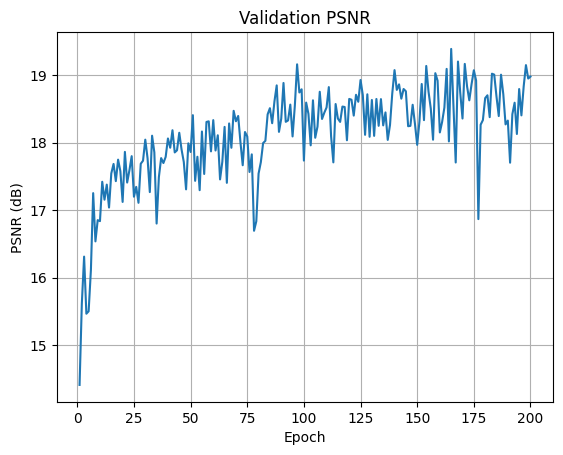

In [100]:
# Validation PSNR
plt.plot(epochs, val_psnr)
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('Validation PSNR')
plt.grid(True)
plt.savefig('validation_psnr.png', dpi=300, bbox_inches='tight')

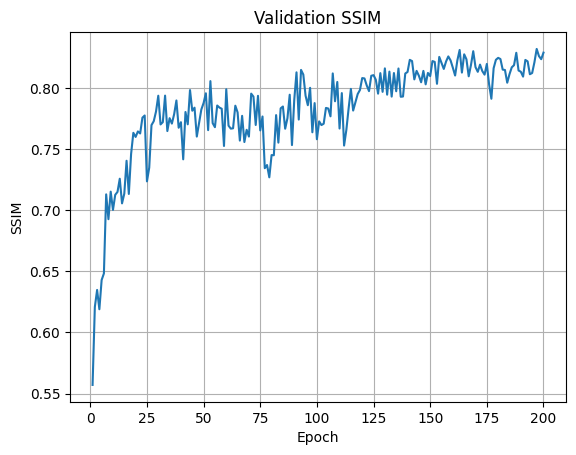

In [101]:
# Validation SSIM

plt.plot(epochs, val_ssim)
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Validation SSIM')
plt.grid(True)
plt.savefig('validation_ssim.png', dpi=300, bbox_inches='tight')

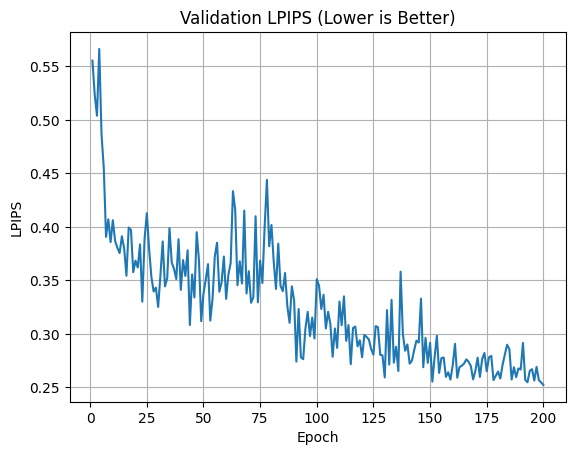

In [102]:
# Validation LPIPS
plt.plot(epochs, val_lpips)
plt.xlabel('Epoch')
plt.ylabel('LPIPS')
plt.title('Validation LPIPS (Lower is Better)')
plt.grid(True)
plt.savefig('validation_lpips.png', dpi=300, bbox_inches='tight')

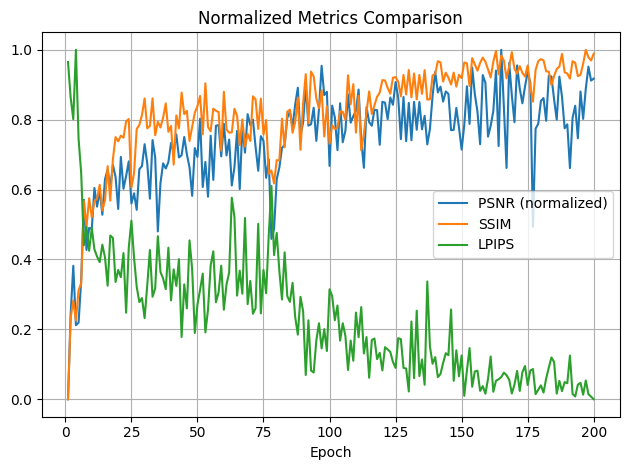

In [103]:
# Combined Metrics
val_psnr_norm = (np.array(val_psnr)-np.min(val_psnr))/(np.max(val_psnr)-np.min(val_psnr))
val_ssim_norm = (np.array(val_ssim)-np.min(val_ssim))/(np.max(val_ssim)-np.min(val_ssim))
val_lpips_norm = (np.array(val_lpips)-np.min(val_lpips))/(np.max(val_lpips)-np.min(val_lpips))

plt.plot(epochs, val_psnr_norm, label='PSNR (normalized)')
plt.plot(epochs, val_ssim_norm, label='SSIM')
plt.plot(epochs, val_lpips_norm, label='LPIPS')
plt.xlabel('Epoch')
plt.title('Normalized Metrics Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

### TESTING ON REAL WORLD IMAGES (CAPTURED BY US)

In [242]:
generator = Generator().to(device)
# Load model with explicit CPU mapping
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS/best_model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [248]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import io
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set device (automatically handles CPU/GPU)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# Image transformations
transform = transforms.Compose([
    transforms.Resize((225, 225)),
    transforms.ToTensor()
])

# Create file upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    clear_output(wait=True)
    display(upload_widget)

    # Load model with proper device mapping
    generator = Generator().to(device)
    state_dict = torch.load("RRDB_SE_CHECKPOINTS/best_model.pth", map_location=device)
    # generator.load_state_dict(state_dict['generator'], strict=False)
    generator.load_state_dict(state_dict) # use this for best model.pth

    # Process uploaded image - NEW WAY to handle file upload
    if not upload_widget.value:
        return

    for filename, file_info in upload_widget.value.items():
        image_bytes = file_info['content']
        pil_image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

        # Transform and process
        input_tensor = transform(pil_image).unsqueeze(0).to(device)

        generator.eval()
        with torch.no_grad():
            enhanced_tensor = generator(input_tensor)

        enhanced_tensor = torch.clamp(enhanced_tensor, 0, 1).cpu().squeeze(0)
        enhanced_image = transforms.ToPILImage()(enhanced_tensor)

        # Display results
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(pil_image)
        plt.title("Original Low-Light")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(enhanced_image)
        plt.title("Enhanced High-Light")
        plt.axis("off")

        plt.show()



FileUpload(value=({'name': 'test_10.jpg', 'type': 'image/jpeg', 'size': 86224, 'content': <memory at 0x7f3897c…

AttributeError: 'tuple' object has no attribute 'items'

In [252]:
def on_upload_change(change):
    clear_output(wait=True)
    display(upload_widget)

    # Load model (with flexible state_dict handling)
    generator = Generator().to(device)
    state_dict = torch.load("RRDB_SE_CHECKPOINTS/best_model.pth", map_location=device)
    if isinstance(state_dict, dict) and 'generator' in state_dict:
        generator.load_state_dict(state_dict['generator'], strict=False)
    else:
        generator.load_state_dict(state_dict, strict=False)

    # Handle new FileUpload value format (tuple of dictionaries)
    if not upload_widget.value:
        return
    
    # Get first uploaded file (even if multiple=False)
    uploaded_file = upload_widget.value[0]  # Gets first tuple element
    
    # Process the image
    image_bytes = uploaded_file['content']
    pil_image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    
    # Transform and process
    input_tensor = transform(pil_image).unsqueeze(0).to(device)
    
    generator.eval()
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)
    
    enhanced_tensor = torch.clamp(enhanced_tensor, 0, 1).cpu().squeeze(0)
    enhanced_image = transforms.ToPILImage()(enhanced_tensor)
    
    # Display results
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(pil_image)
    plt.title("Original Low-Light")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(enhanced_image)
    plt.title("Enhanced High-Light")
    plt.axis("off")
    
    plt.show()

In [251]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=({'name': 'test_2.jpg', 'type': 'image/jpeg', 'size': 61333, 'content': <memory at 0x7f3897ce…

In [254]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=({'name': 'test_2.jpg', 'type': 'image/jpeg', 'size': 61333, 'content': <memory at 0x7f3897ce…

In [1]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

NameError: name 'upload_widget' is not defined

In [2]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

NameError: name 'upload_widget' is not defined

In [3]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

NameError: name 'upload_widget' is not defined